In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Read Data

In [83]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [103]:
test.head()

,id,title,author,text,total
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...","Specter of Trump Loosens Tongues, if Not Purse..."
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,#NoDAPL: Native American Leaders Vow to Stay A...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...","Tim Tebow Will Attempt Another Comeback, This ..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Keiser Report: Meme Wars (E995) Truth Broadcas...


###  Target Value Exploration

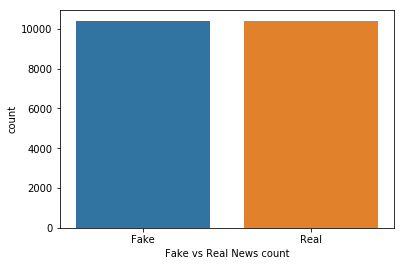

In [85]:
train['label_name'] = train['label'].map({0:'Real', 1:'Fake'})
sns.countplot(train.label_name)
plt.xlabel('Fake vs Real News count')
plt.show()

train.drop('label_name', axis=1, inplace=True)

### Authors

In [86]:
print('Number of Distinct Authors:',train['author'].value_counts().shape[0])

Number of Distinct Authors: 4201


### Sample News Text
Display a Random News text

In [121]:
import random
rand_index = random.randint(0, 20000)
if train.label[rand_index] == 0:
   print('Real News')
else:
  print('Fake News')

print('Author:', train.author[rand_index])
train.text[rand_index]


Fake News
Author: Philip Giraldi


'Written by Philip Giraldi Tuesday November 8, 2016 The American people don’t know very much about war even if Washington has been fighting on multiple fronts since 9/11. The continental United States has not experienced the presence a hostile military force for more than 100 years and war for the current generation of Americans consists largely of the insights provided by video games and movies. The Pentagon’s invention of embedded journalists, which limits any independent media insight into what is going on overseas, has contributed to the rendering of war as some kind of abstraction. Gone forever is anything like the press coverage of Vietnam, with nightly news and other media presentations showing prisoners being executed and young girls screaming while racing down the street in flames. Given all of that, it is perhaps no surprise that both Hillary Clinton and Donald Trump, neither of whom has served in uniform, should regard violence inflicted on people overseas with a considerabl

## Missing data

In [88]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent= (data.isnull().sum() * 100 / data.isnull().count() ).sort_values(ascending = False)
    df = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    return df[df['Total'] != 0]

In [38]:
missing_data(train)

,Total,Percent
author,1957,9.408654
title,558,2.682692
text,39,0.187500


### Data Pre-Processing

In [89]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

In [90]:
train = train.fillna('')
test =  test.fillna('')

In [91]:
train['total']=train['title']+' '+train['author']+' '+train['text']
test['total']= test['title']+' '+test['author']+' '+test['text']

In [92]:
#tfidf
transformer = TfidfTransformer(smooth_idf= False)
count_vectorizer = CountVectorizer(ngram_range= (1,2))
counts = count_vectorizer.fit_transform(train['total'].values)
tfidf =  transformer.fit_transform(counts)

In [95]:
#Prepare Test data
targets = train['label'].values
test_counts = count_vectorizer.transform(test['total'].values)
X_test = transformer.fit_transform(test_counts)

C:\Users\I056036\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1222: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


In [96]:
## Split Train and Validation data
X_train, X_valid, y_train, y_valid = train_test_split(tfidf, targets, random_state = 42, )

## Random Forest

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators= 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
print('Training Accuracy %0.5f' %accuracy_score(y_train, y_pred))

#Predict on Validation Set
y_pred = rf.predict(X_valid)
print('Validation Accuracy %0.5f' %accuracy_score(y_valid, y_pred))

Training Accuracy 1.00000
Validation Accuracy 0.92192


#### Predict on test Set
The submission with prediction on Test set Achived a 92 perecent accuracy on kaggle 

In [116]:
y_pred = rf.predict(X_test)
test_pred = pd.DataFrame(y_pred, columns= ['label'])
test_pred['id'] = test['id']
test_pred.to_csv('rf_preds.csv', index = False)